In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import sklearn

from matplotlib import pyplot as plt

!pip -q install tensorflow_datasets
import tensorflow_datasets as tfds

In [2]:
BATCH_SIZE= 32
AUTOTUNE= tf.data.experimental.AUTOTUNE

In [3]:
(ds_train, ds_test), ds_info= tfds.load(
    'cifar10',
    split= ['train', 'test'],
    shuffle_files= True,
    as_supervised= True,
    with_info= True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteGQXOXW/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incompleteGQXOXW/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


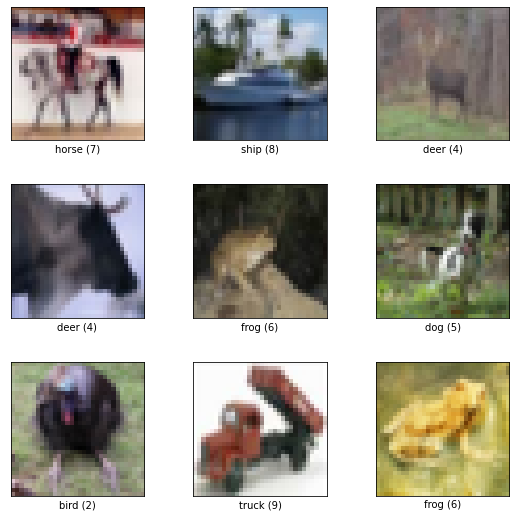

In [4]:
_= tfds.show_examples(ds_train, ds_info, rows=3, cols=3)

In [19]:
CLASS_NAMES= ds_info.features['label'].names

CLASS_NAMES

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [20]:
def norm(img, label):
    img/= 255

    return img, label

In [21]:
ds_train= ds_train.map(norm).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test= ds_test.map(norm).cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [30]:
model= keras.Sequential([
    keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(10, activation='softmax')
])

In [31]:
acc_metric= keras.metrics.SparseCategoricalAccuracy()
loss_fn= keras.losses.SparseCategoricalCrossentropy()
optimizer= keras.optimizers.Adam(0.001)

image_writer = tf.summary.create_file_writer("logs_6/cm_train/")
train_writer = tf.summary.create_file_writer("logs_6/train/")

## Plotting Confusion Matrix on Tensorboard

In [25]:
import io
import sklearn.metrics
from tensorboard.plugins import projector
import cv2
import os
import shutil

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""

    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format="png")

    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)

    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)

    # Add the batch dimension
    image = tf.expand_dims(image, 0)

    return image

def get_confusion_matrix(y_labels, logits, class_names):
    preds = np.argmax(logits, axis=1)
    cm = sklearn.metrics.confusion_matrix(
        y_labels, preds, labels=np.arange(len(class_names)),
    )

    return cm


def plot_confusion_matrix(cm, class_names):
    size = len(class_names)
    figure = plt.figure(figsize=(size, size))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")

    indices = np.arange(len(class_names))
    plt.xticks(indices, class_names, rotation=45)
    plt.yticks(indices, class_names)

    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=3,)

    threshold = cm.max() / 2.0
    for i in range(size):
        for j in range(size):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(
                i, j, cm[i, j], horizontalalignment="center", color=color,
            )

    plt.tight_layout()
    plt.xlabel("True Label")
    plt.ylabel("Predicted label")

    cm_image = plot_to_image(figure)
    return cm_image


In [32]:
num_epochs= 10

for epoch in range(num_epochs):
    confusion = np.zeros((len(CLASS_NAMES), len(CLASS_NAMES)))

    for batch_idx, (x, y) in enumerate(ds_train):
        with tf.GradientTape() as tape:
            y_pred= model(x, training=True)
            loss= loss_fn(y, y_pred)
        
        gradients= tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        acc_metric.update_state(y, y_pred)

        confusion+= get_confusion_matrix(y, y_pred, CLASS_NAMES)

    print(f"Epochs-{epoch+1}\n\nTrain Accuracy: {acc_metric.result()}\nLoss: {loss}\n\n==============================================\n")

    with train_writer.as_default():
        tf.summary.scalar('Loss', loss, step=epoch)
        tf.summary.scalar('Accuracy', acc_metric.result(), step=epoch)

    with image_writer.as_default():
        tf.summary.image(
            "Confusion Matrix", plot_confusion_matrix(confusion / batch_idx, CLASS_NAMES), step=epoch,
        )

    acc_metric.reset_states()

Epochs-1

Train Accuracy: 0.3957599997520447
Loss: 1.775843858718872


Epochs-2

Train Accuracy: 0.5529599785804749
Loss: 1.4355690479278564


Epochs-3

Train Accuracy: 0.6283400058746338
Loss: 0.8153737783432007


Epochs-4

Train Accuracy: 0.6699000000953674
Loss: 0.611016571521759


Epochs-5

Train Accuracy: 0.7084400057792664
Loss: 0.6570169925689697


Epochs-6

Train Accuracy: 0.7360399961471558
Loss: 0.5368807911872864


Epochs-7

Train Accuracy: 0.7542399764060974
Loss: 0.5181614756584167


Epochs-8

Train Accuracy: 0.7735999822616577
Loss: 0.4648614227771759


Epochs-9

Train Accuracy: 0.7928000092506409
Loss: 0.7870942950248718


Epochs-10

Train Accuracy: 0.806659996509552
Loss: 0.36429429054260254




In [33]:
!zip -r /content/logs_6.zip /content/logs_6

  adding: content/logs_6/ (stored 0%)
  adding: content/logs_6/train/ (stored 0%)
  adding: content/logs_6/train/events.out.tfevents.1659444591.2325a0a5407b.70.4.v2 (deflated 62%)
  adding: content/logs_6/train/events.out.tfevents.1659444445.2325a0a5407b.70.2.v2 (deflated 5%)
  adding: content/logs_6/cm_train/ (stored 0%)
  adding: content/logs_6/cm_train/events.out.tfevents.1659444591.2325a0a5407b.70.3.v2 (deflated 10%)
  adding: content/logs_6/cm_train/events.out.tfevents.1659443333.2325a0a5407b.70.0.v2 (deflated 11%)
  adding: content/logs_6/cm_train/events.out.tfevents.1659444445.2325a0a5407b.70.1.v2 (deflated 5%)


In [35]:
# %reload_ext tensorboard
# %tensorboard --logdir=/content/logs_6